In [30]:
import json
import pandas as pd
from yome import Session
from yome.models import *
from yome.util import to_df
import re
from sqlalchemy.orm import aliased
import itertools as it

In [2]:
from mpl_recipes import mpl_setup
%mpl_setup

Populating the interactive namespace from numpy and matplotlib


In [3]:
session = Session()

# Psuedogenes 

In [ ]:
# session.rollback()

In [ ]:
# Genes maked pseudo in EcoGene
ecogene_pseudo = (
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoGene')
    .filter(KnowledgebaseFeature.feature_type == 'is_pseudogene')
    .filter(KnowledgebaseFeature.feature == 't')
)

In [ ]:
ecogene_pseudo.count()

# Genes without b-number

In [46]:
# Genes b4309 pseudo in EcoGene
no_b_number = to_df(
    session.query(KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('kb_name'))
    .join(Knowledgebase)
    .filter(KnowledgebaseGene.gene_id == None)
)

In [47]:
no_b_number.groupby('kb_name').agg('count')

,primary_name,annotation_quality
kb_name,,
EcoCyc,55,55


# Find locus tags with multiple genes

In [41]:
KnowledgebaseGene2 = aliased(KnowledgebaseGene)

In [42]:
duplicates = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene2.primary_name.label('primary_name2'),
                  Knowledgebase.name)
    .join(KnowledgebaseGene, KnowledgebaseGene.gene_id == Gene.id)
    .join(KnowledgebaseGene2, KnowledgebaseGene2.gene_id == Gene.id)
    .join(Knowledgebase, KnowledgebaseGene.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene2.knowledgebase_id == Knowledgebase.id)
    .filter(KnowledgebaseGene.id != KnowledgebaseGene2.id)
)

In [43]:
duplicates

,locus_id,primary_name,primary_name2,name
0,b3504,yhiS_2,yhiS_1,EcoCyc
1,b0240,crl_1,crl_2,EcoCyc
2,b0240,crl_2,crl_1,EcoCyc
3,b3504,yhiS_1,yhiS_2,EcoCyc


# Kbase comparison plot
NOTE: 55 EcoCyc genes without a locus tag and 4 EcoCyc genes with duplicated locud tags are ignored in this plot

In [4]:
kbases = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseGene.annotation_quality,
                  Knowledgebase.name.label('knowledgebase_name'))
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
)

In [5]:
knowledgebase_names = [x[0] for x in session.query(Knowledgebase.name).all()]
knowledgebase_names

['EcoCyc', 'EcoGene', 'UniProt']

In [6]:
levels = {
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
    None: 4
}

In [7]:
# remove duplicate genes
d = kbases.set_index(['locus_id', 'knowledgebase_name'])
d = d[~d.index.duplicated(keep='first')]
d = d.drop('primary_name', axis=1).unstack()
d.columns = d.columns.droplevel(0)
dfp = d.applymap(lambda x: levels[x]).sort_values(by=knowledgebase_names)
dfp.head()

knowledgebase_name,EcoCyc,EcoGene,UniProt
locus_id,,,
b0501,0,1,2
b4274,0,1,2
b0017,0,4,4
b0079,0,4,4
b0100,0,4,4


In [19]:
# create bars based on consecutive colors
last_value = {kbase: None for kbase in knowledgebase_names}
bars = {kbase: [] for kbase in knowledgebase_names}
for locus_tag, row in dfp.iterrows():
    for kbase, value in row.iteritems():
        if len(bars[kbase]) == 0 or bars[kbase][-1]['value'] != value:
            bars[kbase].append({'value': value, 'height': 1})
            last_value[kbase] = value
        else:
            bars[kbase][-1]['height'] += 1

In [12]:
colors = {
    0: 'black',
    1: 'yellow',
    2: 'red',
    3: 'green', 
    4: 'black',
}

In [45]:
bars

{'EcoCyc': [{'height': 37, 'value': 0},
  {'height': 1132, 'value': 1},
  {'height': 1289, 'value': 2},
  {'height': 2150, 'value': 3},
  {'height': 43, 'value': 4}],
 'EcoGene': [{'height': 2, 'value': 1},
  {'height': 35, 'value': 4},
  {'height': 728, 'value': 1},
  {'height': 350, 'value': 2},
  {'height': 54, 'value': 4},
  {'height': 243, 'value': 1},
  {'height': 987, 'value': 2},
  {'height': 59, 'value': 4},
  {'height': 1959, 'value': 1},
  {'height': 190, 'value': 2},
  {'height': 1, 'value': 4},
  {'height': 34, 'value': 1},
  {'height': 9, 'value': 2}],
 'UniProt': [{'height': 2, 'value': 2},
  {'height': 35, 'value': 4},
  {'height': 134, 'value': 1},
  {'height': 203, 'value': 2},
  {'height': 323, 'value': 3},
  {'height': 68, 'value': 4},
  {'height': 45, 'value': 1},
  {'height': 231, 'value': 2},
  {'height': 49, 'value': 3},
  {'height': 25, 'value': 4},
  {'height': 1, 'value': 2},
  {'height': 53, 'value': 4},
  {'height': 24, 'value': 1},
  {'height': 190, 'value

/usr/local/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


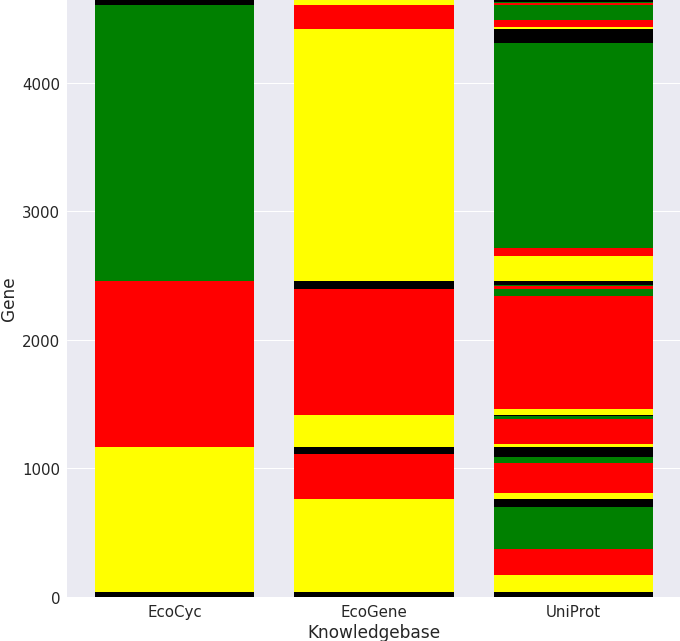

In [49]:
fig, ax = plt.subplots(figsize=(11, 11))
last_heights = [0 for _ in knowledgebase_names]
for bar_list in it.zip_longest(*bars.values()):
    left = [x + 0.1 for x in range(len(knowledgebase_names))]
    height = [x['height'] if x is not None else 0 for x in bar_list]
    bottom = last_heights
    last_heights = [x + y for x, y in zip(height, last_heights)]
    color = [colors[x['value']] if x is not None else 'k' for x in bar_list]
    ax.bar(left, height, bottom=bottom, color=color, linewidth=0)
ax.set_xlabel('Knowledgebase')
ax.set_ylabel('Gene')
ax.xaxis.set_ticks([x + 0.1 for x in range(len(dfp.columns))])
ax.xaxis.set_ticklabels(dfp.columns)